# Modelo con SELF-attention

Vamos a contruir un mecanismo de atención, y vamos a darle un dataser creado a posta para ver como le presta atención a cada zona.

In [10]:
import numpy  as np 
import matplotlib.pyplot as plt 
import torch
from torch import nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset,Dataset, DataLoader, random_split, IterableDataset
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import ExponentialLR
import gc
import math


### Construción mecanismo de atención

Vamos a construir un bloque de atencion con pytorch, que toma in input y procesa la self-atention y luego eso entra a una red densa y ya.

In [ ]:
#primero el scaled dot product
def scaled_dot_prod(q,k,v):
    #multiplicamos q por k y luego de escalarlo y la softmax por v
    d_k=q.size()[-1]
    qk_mult=torch.matmul(q,k.transpose(-2,-1))
    qk_mult_scalet=qk_mult/math.sqrt(d_k)
    attention = F.softmax(qk_mult_scalet, dim=-1)
    attention=torch.eye(*attention.size(),out=attention).flip(-1)
    values = torch.matmul(attention, v)
    return values, attention

In [ ]:
seq_len, d_k = 7, 1
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)
values, attention = scaled_dot_prod(q, k, v)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)

Q
 tensor([[-0.0476],
        [ 0.2206],
        [ 0.3571],
        [ 0.5960],
        [ 1.7237],
        [-0.6713],
        [-0.6513]])
K
 tensor([[-1.3747],
        [ 1.3016],
        [-0.0784],
        [ 1.0663],
        [-0.4982],
        [-0.8816],
        [-0.3101]])
V
 tensor([[ 0.4233],
        [-0.5659],
        [-0.0817],
        [ 1.2227],
        [ 0.8173],
        [ 1.6023],
        [ 2.0337]])
Values
 tensor([[0.7911],
        [0.7137],
        [0.6678],
        [0.5817],
        [0.2349],
        [0.8844],
        [0.8833]])
Attention
 tensor([[0.1516, 0.1335, 0.1425, 0.1350, 0.1454, 0.1481, 0.1441],
        [0.1059, 0.1911, 0.1410, 0.1815, 0.1285, 0.1181, 0.1339],
        [0.0862, 0.2241, 0.1369, 0.2061, 0.1179, 0.1028, 0.1261],
        [0.0578, 0.2850, 0.1252, 0.2477, 0.0975, 0.0776, 0.1091],
        [0.0052, 0.5265, 0.0488, 0.3509, 0.0237, 0.0122, 0.0327],
        [0.2824, 0.0468, 0.1183, 0.0548, 0.1568, 0.2028, 0.1382],
        [0.2779, 0.0486, 0.1194, 0.0567, 0.1570

In [ ]:
#los vectores Q, K y V son creados por combinacion lineal de un imput, por ejemplo
#tenemos las matrics M_Q, M_K y M_V, que tendran dimension (d_input x d_k) y calculamos los vectores resultantes asi input x M_Q = Q
d_input=1 # esta es la dimension de los tokens (puede ser una palabra enmbebida en un espacion de 512 dims, o puede ser una variable o un vector de 3 variables etc.), no la cantidad de tokens
d_k=2 # espacio al que llevamos ese vector o valor del token inicial

vector_input=torch.tensor([1,4,2,1,5,13,3],dtype=torch.float32).unsqueeze(1) #este es el vector de tokens embebidos o variables. La primera dimension recorre las posiciones se la sentencia input
print(vector_input)
M_Q=torch.randn(d_input,d_k)
M_K=torch.randn(d_input,d_k)
M_V=torch.randn(d_input,d_k)

Q=torch.matmul(vector_input,M_Q)
K=torch.matmul(vector_input,M_K)
V=torch.matmul(vector_input,M_V)

print("Q\n", Q)
print("K\n", K)
print("V\n", V)




tensor([[ 1.],
        [ 4.],
        [ 2.],
        [ 1.],
        [ 5.],
        [13.],
        [ 3.]])
Q
 tensor([[ 0.1982,  1.2992],
        [ 0.7930,  5.1967],
        [ 0.3965,  2.5984],
        [ 0.1982,  1.2992],
        [ 0.9912,  6.4959],
        [ 2.5772, 16.8893],
        [ 0.5947,  3.8975]])
K
 tensor([[ 1.4544,  0.7871],
        [ 5.8177,  3.1486],
        [ 2.9088,  1.5743],
        [ 1.4544,  0.7871],
        [ 7.2721,  3.9357],
        [18.9074, 10.2328],
        [ 4.3632,  2.3614]])
V
 tensor([[ 0.8920,  0.9615],
        [ 3.5680,  3.8459],
        [ 1.7840,  1.9230],
        [ 0.8920,  0.9615],
        [ 4.4600,  4.8074],
        [11.5960, 12.4992],
        [ 2.6760,  2.8844]])


In [ ]:
class CustomNetwork(nn.Module):
    #esta implementación es como una MUltiHeadAttention usando self-attentino de All you need is Attention, pero una sola HEAD
    def __init__(self, d_input, d_k, output_dim=1):
        super(CustomNetwork, self).__init__()
        
        self.d_input = d_input
        self.d_k = d_k
        self.M_Q = nn.Parameter(torch.randn(d_input, d_k))
        self.M_K = nn.Parameter(torch.randn(d_input, d_k))
        self.M_V = torch.ones(d_input, d_k) # nn.Parameter(torch.randn(d_input, d_k)) # 
        self.fc = nn.Linear(d_k, output_dim)
        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.M_Q)
        nn.init.xavier_uniform_(self.M_K)        
        #nn.init.xavier_uniform_(self.M_V)
        self.fc.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.fc.weight)
    
    def scaled_dot_prod(self, q, k, v):
        d_k = q.size(-1)
        attn_logits = torch.matmul(q, k.transpose(-2, -1))
        attn_logits /= math.sqrt(d_k)
        attention = F.softmax(attn_logits, dim=-1)
        #batch_dim,dim1,dim2=attention.size()
        #attention_aux=torch.eye(dim1,dim2).flip(-1)
        #attention = attention_aux.unsqueeze(0).expand(batch_dim, -1, -1)
        values = torch.matmul(attention, v)
        return values, attention

    def forward(self, vector_input,return_attention=False):
        Q = torch.matmul(vector_input, self.M_Q)
        K = torch.matmul(vector_input, self.M_K)
        V = torch.matmul(vector_input, self.M_V)
        
        values, attention = self.scaled_dot_prod(Q, K, V)
        output = self.fc(values)
        if return_attention:
            return output, attention
        else:
            return output


In [ ]:
class CustomNetwork2(nn.Module):
    #ahora intentemos implementarlo con la propia capa de Pytorch
    def __init__(self, d_input, d_k, output_dim=1,num_heads=1):
        super(CustomNetwork2, self).__init__()
        
        self.d_input = d_input
        self.d_k = d_k
        self.M_Q = nn.Parameter(torch.randn(d_input, d_k))
        self.M_K = nn.Parameter(torch.randn(d_input, d_k))
        self.M_V = nn.Parameter(torch.randn(d_input, d_k)) 
        self.attention = nn.MultiheadAttention(d_k, num_heads=num_heads,batch_first=True)

        self.fc = nn.Linear(d_k, output_dim)
        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.M_Q)
        nn.init.xavier_uniform_(self.M_K)        
        nn.init.xavier_uniform_(self.M_V)
        self.fc.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.fc.weight)
    


    def forward(self, vector_input,return_attention=False,average_attn_weights=False):
        Q = torch.matmul(vector_input, self.M_Q)
        K = torch.matmul(vector_input, self.M_K)
        V = torch.matmul(vector_input, self.M_V)

        values, attention = self.attention(Q, K, V,average_attn_weights=average_attn_weights)
        #values = values.squeeze(0)

        output = self.fc(values)
        if return_attention:
            return output, attention
        else:
            return output


In [ ]:
class CustomNetwork3(nn.Module):
    #ahora intentemos implementarlo con la propia capa de Pytorch
    def __init__(self, d_input, d_k, output_dim=1,num_heads=1):
        super(CustomNetwork3, self).__init__()
        
        self.d_input = d_input
        self.d_k = d_k
        self.dense=nn.Linear(d_input,d_k)
        self.attention = nn.MultiheadAttention(d_k, num_heads=num_heads,batch_first=True)

        self.fc = nn.Linear(d_k, output_dim)
        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.dense.weight)
               
        #self.fc.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.fc.weight)
    


    def forward(self, vector_input,return_attention=False,average_attn_weights=False):

        x=self.dense(vector_input)

        values, attention = self.attention(x,x,x,average_attn_weights=average_attn_weights)

        output = self.fc(values)
        if return_attention:
            return output, attention
        else:
            return output


In [ ]:
class CustomNetwork4(nn.Module):
    #ahora intentemos implementarlo con la propia capa de Pytorch
    #ademas añadimos conexiones residuales y normalizacion
    def __init__(self, d_input, d_k, output_dim=1,num_heads=1):
        super().__init__()
        
        self.d_input = d_input
        self.d_k = d_k
        self.dense=nn.Linear(d_input,d_k)
        self.attention = nn.MultiheadAttention(d_k, num_heads=num_heads,batch_first=True)
        self.norm1 = nn.LayerNorm(d_k)
        self.norm2 = nn.LayerNorm(d_k)

        self.fc = nn.Linear(d_k, d_k)
        self.last_dense = nn.Linear(d_k, output_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.dense.weight)
               
        #self.fc.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.fc.weight)
    


    def forward(self, vector_input,return_attention=False,average_attn_weights=False):

        x=self.dense(vector_input)

        values, attention = self.attention(x,x,x,average_attn_weights=average_attn_weights)
        values=self.norm1(x+values)
        output = self.last_dense(values)
        #output = self.fc(values)
        #output=self.norm2(x+output)
        #final_output=self.last_dense(output)
        if return_attention:
            return output, attention
        else:
            return output


In [ ]:

class PostionalEncoding(nn.Module):
    """
    compute sinusoid encoding.
    """

    def __init__(self, d_model, max_len, device):
        
        """
        constructor of sinusoid encoding class

        :param d_model: dimension of model
        :param max_len: max sequence length
        :param device: hardware device setting
        """

        super(PostionalEncoding, self).__init__()

        # same size with input matrix (for adding with isnput matrix)
        self.encoding = torch.zeros(max_len, d_model, device=device)
        self.encoding.requires_grad = False  # we don't need to compute gradient

        pos = torch.arange(0, max_len, device=device)
        pos = pos.float().unsqueeze(dim=1)
        # 1D => 2D unsqueeze to represent word's position

        _2i = torch.arange(0, d_model, step=2, device=device).float()
        # 'i' means index of d_model (e.g. embedding size = 50, 'i' = [0,50])
        # "step=2" means 'i' multiplied with two (same with 2 * i)

        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))
        # compute positional encoding to consider positional information of words

    def forward(self, x):
        # self.encoding
        # [max_len = 512, d_model = 512]

        batch_size, seq_len = x.size()
        # [batch_size = 128, seq_len = 30]

        return self.encoding[:seq_len, :]
        # [seq_len = 30, d_model = 512]
        # it will add with tok_emb : [128, 30, 512]

class CustomNetwork4_withPosEncoding(nn.Module):
    #ahora intentemos implementarlo con la propia capa de Pytorch
    #ademas añadimos conexiones residuales y normalizacion
    def __init__(self, d_input, d_k, output_dim=1,num_heads=1):
        super().__init__()
        
        self.d_input = d_input
        self.d_k = d_k
        self.dense=nn.Linear(d_input,d_k)
        self.attention = nn.MultiheadAttention(d_k, num_heads=num_heads,batch_first=True)
        self.norm1 = nn.LayerNorm(d_k)
        self.norm2 = nn.LayerNorm(d_k)
        self.pos_encode=PostionalEncoding(d_input,20,None)

        self.fc = nn.Linear(d_k, d_k)
        self.last_dense = nn.Linear(d_k, output_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.dense.weight)
               
        #self.fc.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.fc.weight)
    


    def forward(self, vector_input,return_attention=False,average_attn_weights=False):
        x=self.pos_encode(vector_input)
        #x=self.dense(x)

        values, attention = self.attention(x,x,x,average_attn_weights=average_attn_weights)
        values=self.norm1(x+values)
        output = self.last_dense(values)
        #output = self.fc(values)
        #output=self.norm2(x+output)
        #final_output=self.last_dense(output)
        if return_attention:
            return output, attention
        else:
            return output


In [ ]:
class CustomNetwork5(nn.Module):
    #ahora intentemos implementarlo con la propia capa de Pytorch
    #ademas añadimos conexiones residuales y normalizacion
    def __init__(self, d_input, d_k, output_dim=1,num_heads=1):
        super().__init__()
        
        self.d_input = d_input
        self.d_k = d_k
        self.dense=nn.Linear(d_input,d_k)
        self.attention = nn.MultiheadAttention(d_k, num_heads=num_heads,batch_first=True)
        self.norm1 = nn.LayerNorm(d_k)
        self.norm2 = nn.LayerNorm(d_k)

        self.fc = nn.Linear(d_k, d_k)
        self.last_dense = nn.Linear(d_k, output_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.dense.weight)
               
        #self.fc.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.fc.weight)
    


    def forward(self, vector_input,return_attention=False,average_attn_weights=False):

        x=self.dense(vector_input)

        values, attention = self.attention(x,x,x,average_attn_weights=average_attn_weights)
        values=self.norm1(x+values)
        output = self.fc(values)
        output=self.norm2(x+output)
        final_output=self.last_dense(output)
        if return_attention:
            return final_output, attention
        else:
            return final_output


In [ ]:
# Parámetros
d_input = 1
len_seq=30
d_k = 2
batch_size=5

# Crear datos de entrada en batch
vector_input = torch.randn(batch_size,len_seq,1)

# Crear una instancia del modelo e inicializarla
model = CustomNetwork(d_input, d_k)

# Pasar los datos en batch a través de la red
output, attention = model(vector_input,return_attention=True)

# Verificar las dimensiones de la salida y la atención
print("Output batch shape:", output.shape)
print("Attention batch shape:", attention.shape)

Output batch shape: torch.Size([5, 30, 1])
Attention batch shape: torch.Size([5, 30, 30])


In [ ]:
"""
import inspect

print(inspect.getmembers(model))  # Obtén todos los miembros del objeto param
print(inspect.signature(model))  # Muestra la firma de la función torch.matmul
print(inspect.getdoc(model))  # Muestra la documentación del objeto param
"""
#ejemplo para ver todos los atributos
for attr in dir(model):
    if not callable(getattr(model, attr)) and not attr.startswith("__"):
        print(f"{attr}: {getattr(model, attr)}")

M_K: Parameter containing:
tensor([[-0.1664,  1.1715]], requires_grad=True)
M_Q: Parameter containing:
tensor([[-1.1030,  0.0070]], requires_grad=True)
M_V: Parameter containing:
tensor([[ 1.3521, -0.8854]], requires_grad=True)
T_destination: ~T_destination
_backward_hooks: OrderedDict()
_buffers: OrderedDict()
_forward_hooks: OrderedDict()
_forward_pre_hooks: OrderedDict()
_is_full_backward_hook: None
_load_state_dict_post_hooks: OrderedDict()
_load_state_dict_pre_hooks: OrderedDict()
_modules: OrderedDict([('fc', Linear(in_features=2, out_features=3, bias=True))])
_non_persistent_buffers_set: set()
_parameters: OrderedDict([('M_Q', Parameter containing:
tensor([[-1.1030,  0.0070]], requires_grad=True)), ('M_K', Parameter containing:
tensor([[-0.1664,  1.1715]], requires_grad=True)), ('M_V', Parameter containing:
tensor([[ 1.3521, -0.8854]], requires_grad=True))])
_state_dict_hooks: OrderedDict()
_version: 1
d_input: 1
d_k: 2
dump_patches: False
training: False


### Dataset

En esta sección construimos un dataset artificial que nos va a permitir ver si el modelo le está prestando atención a la zona que tiene la respuesta que busca.

Esto lo vamos a hacer haciendo un data ser con correspondencias X->y, pero X tiene mucha "basura", tiene muchas zonas que no son las importantes.

Para darle algo que pueda entender tenemos que saber **qué entiende**. El mecanismo que estamos implementado es de self-attention, el más sencillo podriamos decir. Entonces la "pista" que le indique al modelo DONDE mirar y porque, debe estar en la propia sentencia. Por ejemplo, tenemos una vector de vectores/tokens muy largo, queremos que cuando uno del los tokens sea =1 todo, sean las 3 palabras/token/vectores anteriores las que nos den los vectores que si los multiplicamos, nos da el label Y buscado.
 

Vamos a definir un generador de datos, para asi crear nuestro dataset.  
Este puede ser un generador infinito que devuelve X e Y.  

La clave esta en crear una estructura en la secuencia, por ejemplo:
* Cuando un elemento de la secuencia vale 4 o 9, los elementos anteriores, el primero y el tercero anteriores, multiplicados y + 0.3, son igual al label Y buscado.

Para hacerlo hacemos: 
* Vamos a generar vector entre 0 y 100, y vamos a evitar que ninguno valga 4 o 9.
* Metemos en una posicion aleatoria un 4 o un 9 y 1 y 3 posiciones antes, metemos los dos valores que multiplicados y +0.3 son igual a y.  


In [ ]:
def generar_lista(d_list=100,d_randint=100,not_in=[4,9],bias=0.3):
    lista = []
    i = 0
    while len(lista) < d_list:
        i = np.random.randint(0, d_randint)
        if i not in not_in:
            lista.append(i)
        i += 1

    #ahora tenemos la lista, vamos a tomar dos valores aleatorios y calcular y 
    seguir=True
    while seguir:
        i = np.random.randint(0, d_randint)
        if i not in not_in:
            x1=i
            seguir=False
        i += 1
    seguir=True
    while seguir:
        i = np.random.randint(0, d_randint)
        if i not in not_in:
            x2=i
            seguir=False
        i += 1
    y=x1*x2+bias

    #y ahora los colocamos 
    indx_rand=np.random.randint(4, d_list)
    lista[indx_rand]=np.random.choice(not_in)
    lista[indx_rand-1]=x1
    lista[indx_rand-3]=x2
    
    return np.array(lista), y
    


In [ ]:
def get_dataset(size,d_list=100,d_randint=100,not_in=[4,9],bias=0.3):
    X=[]
    y=[]
    for _ in range(size):
        x_element, y_element =generar_lista(d_list=d_list,d_randint=d_randint,not_in=not_in,bias=bias)
        X.append(x_element)
        y.append(y_element)

    return np.array(X),np.array(y)
    

In [ ]:
lista, y =generar_lista()

In [ ]:
a=[]
for i in range(56):
    indx=np.argwhere((lista==4)|(lista==9)).squeeze()
    a.append(lista[indx-1]*lista[indx-3]+0.3==y)


np.all(a)

True

In [ ]:
X,y=get_dataset(10)
print(X.shape,y.shape)

(10, 100) (10,)


## Entrenamiento de la red
Ya tenemos la red y ahora vamos a entrenarla para pode ver su capa de atencion

### Entrenar CustomNetwork2


In [ ]:
#cargamos los datos1
#num_samples=8000
#x_train,y_train=get_dataset(num_samples)
#x_train=np.expand_dims(x_train,-1)

#probamos con los datos2

num_samples=1000
input_dim=1
len_seq=3
x_train=np.random.randint(0,100,(num_samples,len_seq))
y_train=x_train[:,::-1].copy()

x_train,y_train=np.expand_dims(x_train,-1),np.expand_dims(y_train,-1)

x_train,y_train=torch.from_numpy(x_train).float() ,torch.from_numpy(y_train).float()


#instanciamos el modelo
d_k=15
gc.collect()
try:
    del model
except:
    pass
model = CustomNetwork(input_dim, d_k,input_dim)

#creamos la funcion perdida y el optimizador
loss_criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=0.01)
#scheduler = ExponentialLR(optimizer, 0.95)


#creamos los datasets y los dataloaders
train_size = int(0.8 * num_samples)
val_size = num_samples - train_size
train_dataset, val_dataset = random_split(TensorDataset(x_train,y_train), [train_size, val_size])

# Crear DataLoaders para entrenamiento y validación
batch_size=64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
epocas=200


#hacemos un bucle para entrenamiento
for epoca in range(epocas):
    #establecemos el modelo en modo entrenamiento
    model.train()

    #establecemos en 0 el contador de la funcion de perdida
    train_loss=0

    #bucle para recorrer todos los batches
    for batch_x_train,batch_y_train in train_dataloader:
        #ponemos a zero los gradientes para el optimizador
        optimizer.zero_grad()

        #predecimos

        output = model(batch_x_train)

        #calculamos la perdida
        loss = loss_criterion(output,batch_y_train)
        train_loss += loss.item()

        #retropropagamos/calculamso lso gradientes
        loss.backward()
        #y modificamos los pesos
        optimizer.step()

    train_loss /= len(train_dataloader)
    print(f"Epoch {epoca + 1}/{epocas}, Train Loss: {train_loss:.4f}")


    # modo validacion, 
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_x_val,batch_y_val in val_dataloader:
            outputs = model(batch_x_val)
            loss = loss_criterion(outputs, batch_y_val)
            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    print(f"Epoch {epoca + 1}/{epocas}, Validation Loss: {val_loss:.4f}")



Epoch 1/200, Train Loss: 10571.5425
Epoch 1/200, Validation Loss: 5625.1355
Epoch 2/200, Train Loss: 2933.9381
Epoch 2/200, Validation Loss: 1385.7329
Epoch 3/200, Train Loss: 1147.1386
Epoch 3/200, Validation Loss: 1163.1114
Epoch 4/200, Train Loss: 1163.1960
Epoch 4/200, Validation Loss: 1194.2163
Epoch 5/200, Train Loss: 1112.3172
Epoch 5/200, Validation Loss: 1107.8771
Epoch 6/200, Train Loss: 1086.8275
Epoch 6/200, Validation Loss: 1096.6878
Epoch 7/200, Train Loss: 1085.3559
Epoch 7/200, Validation Loss: 1094.7703
Epoch 8/200, Train Loss: 1338.9930
Epoch 8/200, Validation Loss: 1134.1387
Epoch 9/200, Train Loss: 1366.8407
Epoch 9/200, Validation Loss: 697.9342
Epoch 10/200, Train Loss: 911.2641
Epoch 10/200, Validation Loss: 701.3481
Epoch 11/200, Train Loss: 731.4867
Epoch 11/200, Validation Loss: 716.8067
Epoch 12/200, Train Loss: 685.7419
Epoch 12/200, Validation Loss: 702.0722
Epoch 13/200, Train Loss: 668.8643
Epoch 13/200, Validation Loss: 700.5630
Epoch 14/200, Train Loss:

In [ ]:

def plot_attention_heatmap(attention_matrix, labels):
    fig, ax = plt.subplots(figsize=(16,16))
    cax = ax.matshow(attention_matrix, cmap=plt.cm.Blues)

    # Configurar etiquetas de los ejes
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticklabels(labels)

    # Alinear las etiquetas de los ejes a las marcas de graduación
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(1))

    # Agregar una barra de colores
    cbar = fig.colorbar(cax)

In [ ]:
x=torch.randint(0,100,(1,len_seq,1)).float()
print(x)
y,att=model(x,return_attention=True)
print(y)
print(att)

tensor([[[12.],
         [58.],
         [46.]]])
tensor([[[38.9905],
         [38.9905],
         [38.9905]]], grad_fn=<ViewBackward0>)
tensor([[[0.0000e+00, 1.0000e+00, 1.9153e-22],
         [0.0000e+00, 1.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00]]], grad_fn=<SoftmaxBackward0>)


/tmp/ipykernel_10244/1681730846.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)
/tmp/ipykernel_10244/1681730846.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


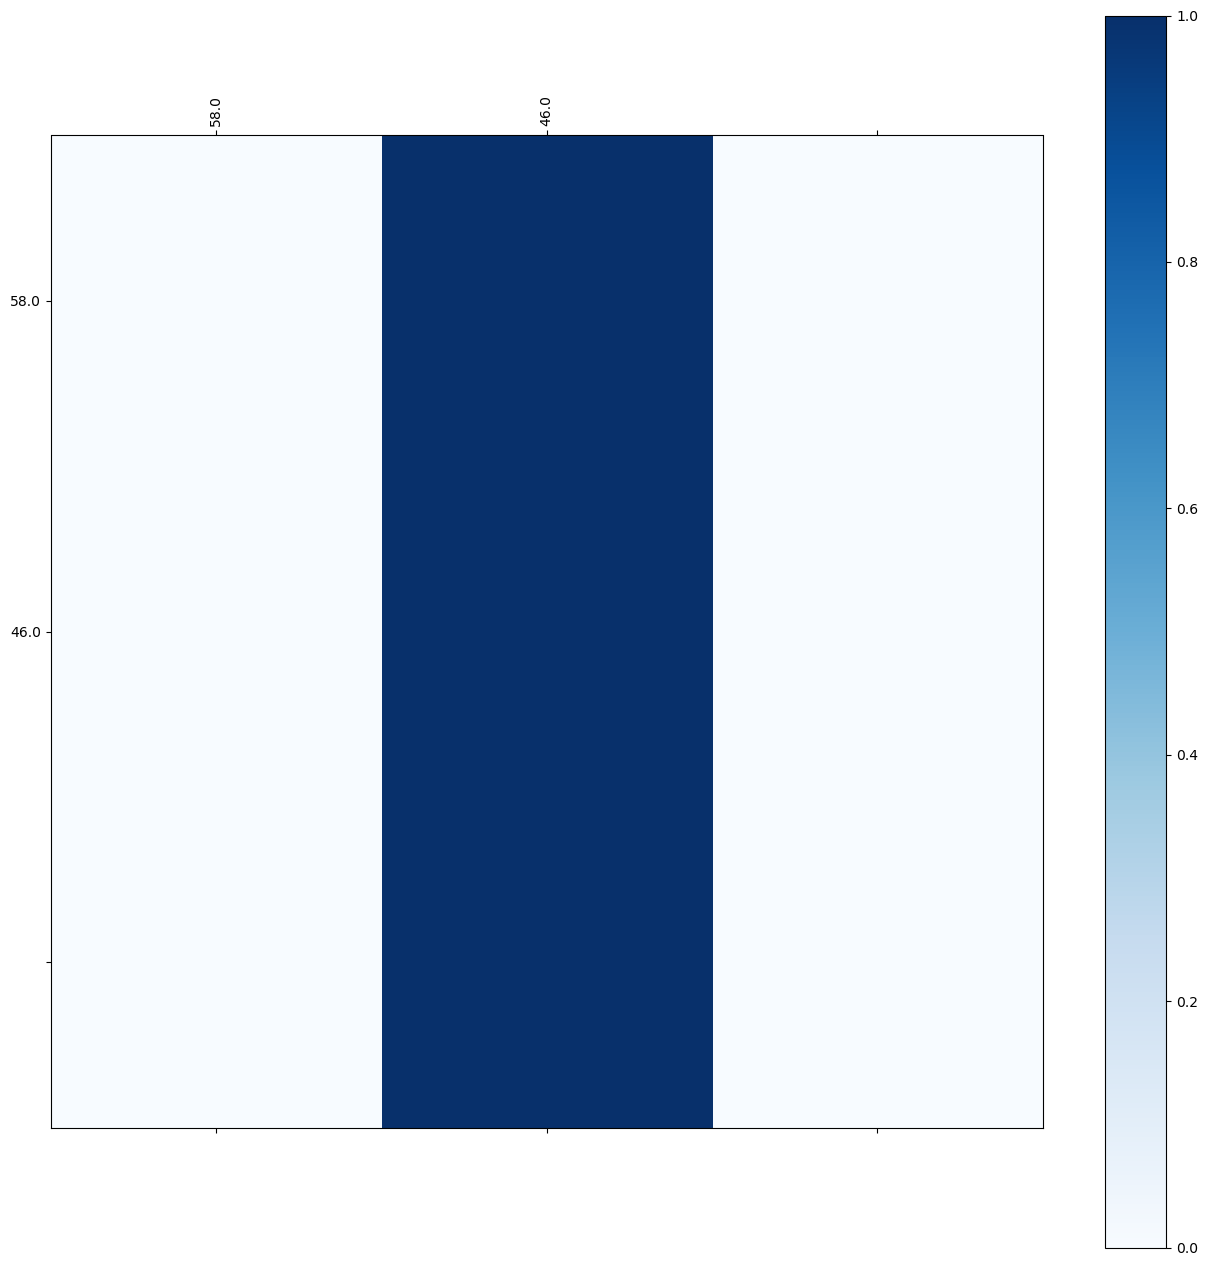

In [ ]:
plot_attention_heatmap(att.detach().squeeze().numpy(),x.detach().squeeze().numpy())

### Entrenar CustomNetwork2


In [ ]:
#entrenamos la red con la implementacion del pytorch
#cargamos los datos1
#num_samples=8000
#x_train,y_train=get_dataset(num_samples)
#x_train=np.expand_dims(x_train,-1)

#probamos con los datos2

num_samples=1000
input_dim=1
len_seq=3
x_train=np.random.randint(0,100,(num_samples,len_seq))
y_train=x_train[:,::-1].copy()

x_train,y_train=np.expand_dims(x_train,-1),np.expand_dims(y_train,-1)

x_train,y_train=torch.from_numpy(x_train).float() ,torch.from_numpy(y_train).float()


#instanciamos el modelo
d_k=64
gc.collect()
try:
    del model
except:
    pass
model = CustomNetwork2(input_dim, d_k,input_dim,num_heads=4)

#creamos la funcion perdida y el optimizador
loss_criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=0.01)
#scheduler = ExponentialLR(optimizer, 0.95)


#creamos los datasets y los dataloaders
train_size = int(0.8 * num_samples)
val_size = num_samples - train_size
train_dataset, val_dataset = random_split(TensorDataset(x_train,y_train), [train_size, val_size])

# Crear DataLoaders para entrenamiento y validación
batch_size=64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
epocas=200


#hacemos un bucle para entrenamiento
for epoca in range(epocas):
    #establecemos el modelo en modo entrenamiento
    model.train()

    #establecemos en 0 el contador de la funcion de perdida
    train_loss=0

    #bucle para recorrer todos los batches
    for batch_x_train,batch_y_train in train_dataloader:
        #ponemos a zero los gradientes para el optimizador
        optimizer.zero_grad()

        #predecimos

        output = model(batch_x_train)

        #calculamos la perdida
        loss = loss_criterion(output,batch_y_train)
        train_loss += loss.item()

        #retropropagamos/calculamso lso gradientes
        loss.backward()
        #y modificamos los pesos
        optimizer.step()

    train_loss /= len(train_dataloader)
    print(f"Epoch {epoca + 1}/{epocas}, Train Loss: {train_loss:.4f}")


    # modo validacion, 
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_x_val,batch_y_val in val_dataloader:
            outputs = model(batch_x_val)
            loss = loss_criterion(outputs, batch_y_val)
            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    print(f"Epoch {epoca + 1}/{epocas}, Validation Loss: {val_loss:.4f}")



Epoch 1/200, Train Loss: 1017.4464
Epoch 1/200, Validation Loss: 588.5538
Epoch 2/200, Train Loss: 654.2844
Epoch 2/200, Validation Loss: 964.6838
Epoch 3/200, Train Loss: 691.4332
Epoch 3/200, Validation Loss: 546.1404
Epoch 4/200, Train Loss: 597.3898
Epoch 4/200, Validation Loss: 557.1630
Epoch 5/200, Train Loss: 582.3827
Epoch 5/200, Validation Loss: 535.5259
Epoch 6/200, Train Loss: 582.1234
Epoch 6/200, Validation Loss: 532.4084
Epoch 7/200, Train Loss: 578.7372
Epoch 7/200, Validation Loss: 535.4134
Epoch 8/200, Train Loss: 581.9578
Epoch 8/200, Validation Loss: 536.2614
Epoch 9/200, Train Loss: 580.8549
Epoch 9/200, Validation Loss: 537.4352
Epoch 10/200, Train Loss: 577.8993
Epoch 10/200, Validation Loss: 536.6995
Epoch 11/200, Train Loss: 584.0578
Epoch 11/200, Validation Loss: 536.1711
Epoch 12/200, Train Loss: 579.9230
Epoch 12/200, Validation Loss: 534.3603
Epoch 13/200, Train Loss: 577.5793
Epoch 13/200, Validation Loss: 542.4921
Epoch 14/200, Train Loss: 576.1330
Epoch 1

### Pruebas con MultiHeadAttention layer

In [ ]:
x=torch.randint(0,100,(1,len_seq,1)).float()
print(x)
y,att=model(x,return_attention=True,average_attn_weights=False)
print(y)
print(att)

tensor([[[83.],
         [76.],
         [91.]]])
tensor([[81.9744],
        [81.9744],
        [81.9744]], grad_fn=<AddmmBackward0>)
tensor([[[[0., 1., 0.],
          [0., 1., 0.],
          [0., 1., 0.]],

         [[0., 0., 1.],
          [0., 0., 1.],
          [0., 0., 1.]],

         [[0., 1., 0.],
          [0., 1., 0.],
          [0., 1., 0.]],

         [[0., 1., 0.],
          [0., 1., 0.],
          [0., 1., 0.]]]], grad_fn=<ViewBackward0>)


In [ ]:
len_seq=10
d_k=20
input_dim=1
batch_dim=32
x=torch.randn(batch_dim,len_seq,d_k)
Q=torch.randn(batch_dim,len_seq,d_k)
K=torch.randn(batch_dim,len_seq,d_k)
V=torch.randn(batch_dim,len_seq,d_k)

In [ ]:
attention = nn.MultiheadAttention(d_k, num_heads=1,batch_first=True)

In [ ]:
value,attn=attention(x,x,x)
print(value.shape,attn.shape)

torch.Size([32, 10, 20]) torch.Size([32, 10, 10])


### Entrenar CustomNetwork3


In [ ]:
#entrenamos la red con la implementacion del pytorch
#cargamos los datos1
#num_samples=8000
#x_train,y_train=get_dataset(num_samples)
#x_train=np.expand_dims(x_train,-1)

#probamos con los datos2

num_samples=1000
input_dim=1
len_seq=3
x_train=np.random.randint(0,100,(num_samples,len_seq))
y_train=x_train[:,::-1].copy()

x_train,y_train=np.expand_dims(x_train,-1),np.expand_dims(y_train,-1)

x_train,y_train=torch.from_numpy(x_train).float() ,torch.from_numpy(y_train).float()


#instanciamos el modelo
d_k=64
gc.collect()
try:
    del model
except:
    pass
model = CustomNetwork3(input_dim, d_k,input_dim,num_heads=4)

#creamos la funcion perdida y el optimizador
loss_criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=0.01)
#scheduler = ExponentialLR(optimizer, 0.95)


#creamos los datasets y los dataloaders
train_size = int(0.8 * num_samples)
val_size = num_samples - train_size
train_dataset, val_dataset = random_split(TensorDataset(x_train,y_train), [train_size, val_size])

# Crear DataLoaders para entrenamiento y validación
batch_size=64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
epocas=200


#hacemos un bucle para entrenamiento
for epoca in range(epocas):
    #establecemos el modelo en modo entrenamiento
    model.train()

    #establecemos en 0 el contador de la funcion de perdida
    train_loss=0

    #bucle para recorrer todos los batches
    for batch_x_train,batch_y_train in train_dataloader:
        #ponemos a zero los gradientes para el optimizador
        optimizer.zero_grad()

        #predecimos

        output = model(batch_x_train)

        #calculamos la perdida
        loss = loss_criterion(output,batch_y_train)
        train_loss += loss.item()

        #retropropagamos/calculamso lso gradientes
        loss.backward()
        #y modificamos los pesos
        optimizer.step()

    train_loss /= len(train_dataloader)
    print(f"Epoch {epoca + 1}/{epocas}, Train Loss: {train_loss:.4f}")


    # modo validacion, 
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_x_val,batch_y_val in val_dataloader:
            outputs = model(batch_x_val)
            loss = loss_criterion(outputs, batch_y_val)
            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    print(f"Epoch {epoca + 1}/{epocas}, Validation Loss: {val_loss:.4f}")



Epoch 1/200, Train Loss: 1269.6548
Epoch 1/200, Validation Loss: 827.7826
Epoch 2/200, Train Loss: 690.1705
Epoch 2/200, Validation Loss: 591.2638
Epoch 3/200, Train Loss: 603.2746
Epoch 3/200, Validation Loss: 551.4520
Epoch 4/200, Train Loss: 583.5020
Epoch 4/200, Validation Loss: 544.1393
Epoch 5/200, Train Loss: 578.4459
Epoch 5/200, Validation Loss: 543.6025
Epoch 6/200, Train Loss: 583.2575
Epoch 6/200, Validation Loss: 544.2557
Epoch 7/200, Train Loss: 576.2405
Epoch 7/200, Validation Loss: 543.6211
Epoch 8/200, Train Loss: 579.1571
Epoch 8/200, Validation Loss: 543.1811
Epoch 9/200, Train Loss: 583.4442
Epoch 9/200, Validation Loss: 543.7884
Epoch 10/200, Train Loss: 578.9010
Epoch 10/200, Validation Loss: 542.9674
Epoch 11/200, Train Loss: 584.4840
Epoch 11/200, Validation Loss: 543.6751
Epoch 12/200, Train Loss: 576.3864
Epoch 12/200, Validation Loss: 543.5571
Epoch 13/200, Train Loss: 580.1746
Epoch 13/200, Validation Loss: 543.4741
Epoch 14/200, Train Loss: 579.7872
Epoch 1

In [ ]:
x=torch.randint(0,100,(1,len_seq,1)).float()
print(x)
y,att=model(x,return_attention=True,average_attn_weights=False)
print(y)
print(att)


tensor([[[22.],
         [57.],
         [36.]]])
tensor([[[39.5671],
         [39.5671],
         [39.5671]]], grad_fn=<ViewBackward0>)
tensor([[[[1.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.0000e+00, 0.0000e+00, 0.0000e+00]],

         [[1.0000e+00, 1.2935e-32, 1.7567e-13],
          [1.0000e+00, 0.0000e+00, 7.9328e-27],
          [1.0000e+00, 0.0000e+00, 8.0649e-19]],

         [[1.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.0000e+00, 0.0000e+00, 0.0000e+00]],

         [[0.0000e+00, 1.0000e+00, 2.9007e-43],
          [0.0000e+00, 1.0000e+00, 0.0000e+00],
          [0.0000e+00, 1.0000e+00, 0.0000e+00]]]], grad_fn=<ViewBackward0>)


### Entrenar CustomNetwork4

In [ ]:
#entrenamos la red con la implementacion del pytorch
#cargamos los datos1
#num_samples=8000
#x_train,y_train=get_dataset(num_samples)
#x_train=np.expand_dims(x_train,-1)

#probamos con los datos2

num_samples=30000
input_dim=1
len_seq=3
x_train=np.random.randint(0,100,(num_samples,len_seq))
y_train=x_train[:,::-1].copy()

x_train,y_train=np.expand_dims(x_train,-1),np.expand_dims(y_train,-1)

x_train,y_train=torch.from_numpy(x_train).float() ,torch.from_numpy(y_train).float()


#instanciamos el modelo
d_k=120
gc.collect()
try:
    del model
except:
    pass
model = CustomNetwork5(input_dim, d_k,input_dim,num_heads=4)

#creamos la funcion perdida y el optimizador
loss_criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)
#scheduler = ExponentialLR(optimizer, 0.95)


#creamos los datasets y los dataloaders
train_size = int(0.8 * num_samples)
val_size = num_samples - train_size
train_dataset, val_dataset = random_split(TensorDataset(x_train,y_train), [train_size, val_size])

# Crear DataLoaders para entrenamiento y validación
batch_size=128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
epocas=30


#hacemos un bucle para entrenamiento
for epoca in range(epocas):
    #establecemos el modelo en modo entrenamiento
    model.train()

    #establecemos en 0 el contador de la funcion de perdida
    train_loss=0

    #bucle para recorrer todos los batches
    for batch_x_train,batch_y_train in train_dataloader:
        #ponemos a zero los gradientes para el optimizador
        optimizer.zero_grad()

        #predecimos

        output = model(batch_x_train)

        #calculamos la perdida
        loss = loss_criterion(output,batch_y_train)
        train_loss += loss.item()

        #retropropagamos/calculamso lso gradientes
        loss.backward()
        #y modificamos los pesos
        optimizer.step()

    train_loss /= len(train_dataloader)
    print(f"Epoch {epoca + 1}/{epocas}, Train Loss: {train_loss:.4f}")


    # modo validacion, 
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_x_val,batch_y_val in val_dataloader:
            outputs = model(batch_x_val)
            loss = loss_criterion(outputs, batch_y_val)
            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    print(f"Epoch {epoca + 1}/{epocas}, Validation Loss: {val_loss:.4f}")



Epoch 1/30, Train Loss: 2000.9459
Epoch 1/30, Validation Loss: 1126.8336
Epoch 2/30, Train Loss: 814.2508
Epoch 2/30, Validation Loss: 659.2357
Epoch 3/30, Train Loss: 622.1192
Epoch 3/30, Validation Loss: 598.9983
Epoch 4/30, Train Loss: 596.1869
Epoch 4/30, Validation Loss: 585.2652
Epoch 5/30, Train Loss: 589.7725
Epoch 5/30, Validation Loss: 585.2767
Epoch 6/30, Train Loss: 587.5596
Epoch 6/30, Validation Loss: 583.2285
Epoch 7/30, Train Loss: 586.8403
Epoch 7/30, Validation Loss: 583.2864
Epoch 8/30, Train Loss: 586.0861
Epoch 8/30, Validation Loss: 578.7184
Epoch 9/30, Train Loss: 584.9948
Epoch 9/30, Validation Loss: 578.2278
Epoch 10/30, Train Loss: 585.1269
Epoch 10/30, Validation Loss: 579.3866
Epoch 11/30, Train Loss: 584.6913
Epoch 11/30, Validation Loss: 582.3831
Epoch 12/30, Train Loss: 584.7779
Epoch 12/30, Validation Loss: 578.2818
Epoch 13/30, Train Loss: 584.4605
Epoch 13/30, Validation Loss: 578.9738
Epoch 14/30, Train Loss: 584.1538
Epoch 14/30, Validation Loss: 577

In [ ]:
x=torch.randint(0,100,(1,len_seq,1)).float()
print(x)
y,att=model(x,return_attention=True,average_attn_weights=False)
print(y)
print(att)


tensor([[[64.],
         [ 4.]]])
tensor([[[ 3.9368],
         [65.4299]]], grad_fn=<ViewBackward0>)
tensor([[[[0.0000e+00, 1.0000e+00],
          [0.0000e+00, 1.0000e+00]],

         [[1.8551e-28, 1.0000e+00],
          [1.0000e+00, 4.5442e-11]],

         [[9.9992e-01, 8.4177e-05],
          [1.0000e+00, 1.6283e-09]],

         [[0.0000e+00, 1.0000e+00],
          [1.0000e+00, 2.3903e-08]]]], grad_fn=<ViewBackward0>)


### Custom positional encoding

In [ ]:
num_samples=70000
input_dim=2
len_seq=3
x_train=np.random.randint(0,100,(num_samples,len_seq))

y_train=x_train[:,::-1].copy()

x_train,y_train=np.expand_dims(x_train,-1),np.expand_dims(y_train,-1)
x_train_pos=np.array([np.hstack((np.arange(len_seq)[...,np.newaxis],x)) for x in x_train])
x_train=x_train_pos.sum(-1)[...,np.newaxis]

array([[[20],
        [25],
        [40]],

       [[95],
        [24],
        [40]],

       [[57],
        [41],
        [58]],

       ...,

       [[64],
        [81],
        [83]],

       [[19],
        [68],
        [65]],

       [[46],
        [66],
        [62]]])

In [ ]:
#entrenamos la red con la implementacion del pytorch
#cargamos los datos1
#num_samples=8000
#x_train,y_train=get_dataset(num_samples)
#x_train=np.expand_dims(x_train,-1)

#probamos con los datos2

num_samples=170000
input_dim=1
len_seq=3
x_train=np.random.randn(num_samples,len_seq)

y_train=x_train[:,::-1].copy()

x_train,y_train=np.expand_dims(x_train,-1),np.expand_dims(y_train,-1)
x_train_pos=np.array([np.hstack((np.arange(len_seq)[...,np.newaxis],x)) for x in x_train])
x_train=x_train_pos.sum(-1)[...,np.newaxis]
x_train,y_train=torch.from_numpy(x_train).float() ,torch.from_numpy(y_train).float()


#instanciamos el modelo
d_k=24
gc.collect()
try:
    del model
except:
    pass
model = CustomNetwork5(input_dim, d_k,1,num_heads=4)

#creamos la funcion perdida y el optimizador
loss_criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=0.0001)
#scheduler = ExponentialLR(optimizer, 0.95)


#creamos los datasets y los dataloaders
train_size = int(0.8 * num_samples)
val_size = num_samples - train_size
train_dataset, val_dataset = random_split(TensorDataset(x_train,y_train), [train_size, val_size])

# Crear DataLoaders para entrenamiento y validación
batch_size=128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
epocas=40


#hacemos un bucle para entrenamiento
for epoca in range(epocas):
    #establecemos el modelo en modo entrenamiento
    model.train()

    #establecemos en 0 el contador de la funcion de perdida
    train_loss=0

    #bucle para recorrer todos los batches
    for batch_x_train,batch_y_train in train_dataloader:
        #ponemos a zero los gradientes para el optimizador
        optimizer.zero_grad()

        #predecimos

        output = model(batch_x_train)

        #calculamos la perdida
        loss = loss_criterion(output,batch_y_train)
        train_loss += loss.item()

        #retropropagamos/calculamso lso gradientes
        loss.backward()
        #y modificamos los pesos
        optimizer.step()

    train_loss /= len(train_dataloader)
    print(f"Epoch {epoca + 1}/{epocas}, Train Loss: {train_loss:.4f}")


    # modo validacion, 
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_x_val,batch_y_val in val_dataloader:
            outputs = model(batch_x_val)
            loss = loss_criterion(outputs, batch_y_val)
            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    print(f"Epoch {epoca + 1}/{epocas}, Validation Loss: {val_loss:.4f}")



Epoch 1/40, Train Loss: 0.7992
Epoch 1/40, Validation Loss: 0.6420
Epoch 2/40, Train Loss: 0.6304
Epoch 2/40, Validation Loss: 0.6219
Epoch 3/40, Train Loss: 0.6182
Epoch 3/40, Validation Loss: 0.6143
Epoch 4/40, Train Loss: 0.6135
Epoch 4/40, Validation Loss: 0.6117
Epoch 5/40, Train Loss: 0.6113
Epoch 5/40, Validation Loss: 0.6098
Epoch 6/40, Train Loss: 0.6100
Epoch 6/40, Validation Loss: 0.6088
Epoch 7/40, Train Loss: 0.6093
Epoch 7/40, Validation Loss: 0.6081
Epoch 8/40, Train Loss: 0.6087
Epoch 8/40, Validation Loss: 0.6073
Epoch 9/40, Train Loss: 0.6081
Epoch 9/40, Validation Loss: 0.6066
Epoch 10/40, Train Loss: 0.6075
Epoch 10/40, Validation Loss: 0.6063
Epoch 11/40, Train Loss: 0.6069
Epoch 11/40, Validation Loss: 0.6053
Epoch 12/40, Train Loss: 0.6058
Epoch 12/40, Validation Loss: 0.6040
Epoch 13/40, Train Loss: 0.6040
Epoch 13/40, Validation Loss: 0.6025
Epoch 14/40, Train Loss: 0.6014
Epoch 14/40, Validation Loss: 0.5987
Epoch 15/40, Train Loss: 0.5993
Epoch 15/40, Validat

In [ ]:
x=torch.randint(0,100,(len_seq,1)).float()
x

tensor([[38.],
        [86.],
        [85.]])

In [ ]:
len_seq=3
x=torch.randint(0,100,(1,len_seq,1)).float()
x=np.array([np.hstack((np.arange(len_seq)[...,np.newaxis],i)) for i in x])
x=torch.from_numpy(x).float() 

print(x)
y,att=model(x,return_attention=True,average_attn_weights=False)
print(y)
print(att)

tensor([[[ 0., 31.],
         [ 1., 84.],
         [ 2., 82.]]])
tensor([[[84.7435],
         [87.5554],
         [32.0334]]], grad_fn=<ViewBackward0>)
tensor([[[[0.9519, 0.0231, 0.0251],
          [0.9113, 0.0509, 0.0377],
          [0.6461, 0.1880, 0.1659]],

         [[0.0828, 0.2635, 0.6537],
          [0.2157, 0.2805, 0.5038],
          [0.5074, 0.2192, 0.2734]],

         [[0.9866, 0.0069, 0.0066],
          [0.9088, 0.0650, 0.0262],
          [0.7080, 0.2536, 0.0384]],

         [[0.5075, 0.3043, 0.1882],
          [0.2268, 0.3108, 0.4624],
          [0.0910, 0.1999, 0.7092]]]], grad_fn=<ViewBackward0>)


## Con positional encoding

In [ ]:
import torch
import torch.nn as nn

class CustomNetwork4_withPosEncoding(nn.Module):
    def __init__(self, d_input, d_k, output_dim=1, num_heads=1, max_seq_length=200):
        super().__init__()
        
        self.d_input = d_input
        self.d_k = d_k
        self.dense = nn.Linear(d_input, d_k)
        self.attention = nn.MultiheadAttention(d_k, num_heads=num_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(d_k)
        self.norm2 = nn.LayerNorm(d_k)

        self.fc = nn.Linear(d_k, d_k)
        self.last_dense = nn.Linear(d_k, output_dim)

        self.max_seq_length = max_seq_length
        self.positional_encoding = self.generate_positional_encoding(self.max_seq_length, self.d_k)

        self._reset_parameters()

    def generate_positional_encoding(self, max_seq_length, d_k):
        positional_encoding = torch.zeros(max_seq_length, d_k)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(-1)
        div_term = torch.exp(torch.arange(0, d_k, 2).float() * -(math.log(10000.0) / d_k))
        positional_encoding[:, 0::2] = torch.sin(position * div_term)
        positional_encoding[:, 1::2] = torch.cos(position * div_term)
        positional_encoding = positional_encoding.unsqueeze(0).transpose(0, 1)
        return positional_encoding

    def _reset_parameters(self):
        nn.init.xavier_uniform_(self.dense.weight)
        nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, vector_input, return_attention=False, average_attn_weights=False):
        x = self.dense(vector_input)
        
        # Add positional encoding
        x = x + self.positional_encoding[:x.size(0), :]

        values, attention = self.attention(x, x, x, average_attn_weights=average_attn_weights)
        values = self.norm1(x + values)
        output = self.last_dense(values)

        if return_attention:
            return output, attention
        else:
            return output


In [ ]:

#entrenamos la red con la implementacion del pytorch
#cargamos los datos1
#num_samples=8000
#x_train,y_train=get_dataset(num_samples)
#x_train=np.expand_dims(x_train,-1)

#probamos con los datos2

num_samples=6000
input_dim=1
len_seq=3
x_train=np.random.randn(num_samples,len_seq)
y_train=x_train[:,::-1].copy()

x_train,y_train=np.expand_dims(x_train,-1),np.expand_dims(y_train,-1)

x_train,y_train=torch.from_numpy(x_train).float() ,torch.from_numpy(y_train).float()


#instanciamos el modelo
d_k=10
gc.collect()
try:
    del model
except:
    pass
model = CustomNetwork4_withPosEncoding(input_dim, d_k,input_dim,num_heads=2)

#creamos la funcion perdida y el optimizador
loss_criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)
#scheduler = ExponentialLR(optimizer, 0.95)


#creamos los datasets y los dataloaders
train_size = int(0.8 * num_samples)
val_size = num_samples - train_size
train_dataset, val_dataset = random_split(TensorDataset(x_train,y_train), [train_size, val_size])

# Crear DataLoaders para entrenamiento y validación
batch_size=32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
epocas=130


#hacemos un bucle para entrenamiento
for epoca in range(epocas):
    #establecemos el modelo en modo entrenamiento
    model.train()

    #establecemos en 0 el contador de la funcion de perdida
    train_loss=0

    #bucle para recorrer todos los batches
    for batch_x_train,batch_y_train in train_dataloader:
        #ponemos a zero los gradientes para el optimizador
        optimizer.zero_grad()

        #predecimos

        output = model(batch_x_train)

        #calculamos la perdida
        loss = loss_criterion(output,batch_y_train)
        train_loss += loss.item()

        #retropropagamos/calculamso lso gradientes
        loss.backward()
        #y modificamos los pesos
        optimizer.step()

    train_loss /= len(train_dataloader)
    print(f"Epoch {epoca + 1}/{epocas}, Train Loss: {train_loss:.4f}")


    # modo validacion, 
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_x_val,batch_y_val in val_dataloader:
            outputs = model(batch_x_val)
            loss = loss_criterion(outputs, batch_y_val)
            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    print(f"Epoch {epoca + 1}/{epocas}, Validation Loss: {val_loss:.4f}")



Epoch 1/130, Train Loss: 1.0497
Epoch 1/130, Validation Loss: 0.7196
Epoch 2/130, Train Loss: 0.7063
Epoch 2/130, Validation Loss: 0.6702
Epoch 3/130, Train Loss: 0.6837
Epoch 3/130, Validation Loss: 0.6632
Epoch 4/130, Train Loss: 0.6792
Epoch 4/130, Validation Loss: 0.6605
Epoch 5/130, Train Loss: 0.6788
Epoch 5/130, Validation Loss: 0.6585
Epoch 6/130, Train Loss: 0.6755
Epoch 6/130, Validation Loss: 0.6619


KeyboardInterrupt: 

In [ ]:
x=torch.randn(1,len_seq,1).float()
print(x)
y,att=model(x,return_attention=True,average_attn_weights=False)
print(y)
print(att)

tensor([[[1.1172],
         [0.7123]]])
tensor([[[0.7095],
         [1.1009]]], grad_fn=<ViewBackward0>)
tensor([[[[0.4725, 0.5275],
          [0.4732, 0.5268]],

         [[0.5407, 0.4593],
          [0.5401, 0.4599]]]], grad_fn=<ViewBackward0>)


TypeError: Invalid shape (200, 1, 10) for image data

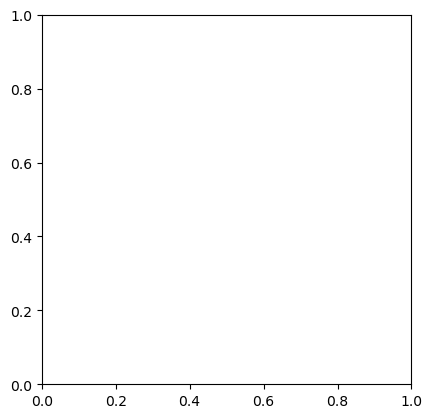

In [ ]:
plt.imshow(model.positional_encoding)

### Implementación seq2seq con GRU y attencion Bahnaudsdfsasd 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        embedded = self.embedding(x)
        outputs, hidden = self.gru(embedded)
        return outputs, hidden

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))

    def forward(self, hidden, encoder_outputs):
        attn_weights = torch.sum(hidden * encoder_outputs, dim=2)
        attn_weights = F.softmax(attn_weights, dim=1).unsqueeze(1)
        context = attn_weights.bmm(encoder_outputs)
        return context, attn_weights

class Decoder(nn.Module):
    def __init__(self, output_size, hidden_size, num_layers=1):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size  # Agrega esta línea

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, num_layers, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden, context):
        x = self.embedding(x)
        x = torch.cat((x, context), dim=2)
        output, hidden = self.gru(x, hidden)
        output = self.softmax(self.out(output.squeeze(1)))
        return output, hidden


class Seq2Seq(nn.Module):
    def __init__(self, encoder, attention, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.attention = attention
        self.decoder = decoder

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)
        max_len = trg.size(1)
        trg_vocab_size = self.decoder.output_size

        outputs = torch.zeros(batch_size, max_len, trg_vocab_size).to(src.device)

        encoder_outputs, hidden = self.encoder(src)

        x = trg[:, 0]

        for t in range(1, max_len):
            context, _ = self.attention(hidden, encoder_outputs)
            output, hidden = self.decoder(x.unsqueeze(1), hidden, context)
            outputs[:, t] = output

            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            x = (trg[:, t] if teacher_force else output.argmax(1))

        return outputs


In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable

class VectorInversionDataset(Dataset):
    def __init__(self, vector_length, dataset_size):
        self.vector_length = vector_length
        self.dataset_size = dataset_size

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        x = torch.randint(1, 10, (self.vector_length,))
        y = torch.flip(x, [0])
        return x, y

# Ajusta la línea en la clase Seq2Seq

# Modifica la función de entrenamiento
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0

    for src, trg in dataloader:
        src, trg = src.to(device), trg.to(device)

        optimizer.zero_grad()
        output = model(src, trg)

        output = output[:, 1:].reshape(-1, output.shape[-1])
        trg = trg[:, 1:].reshape(-1)

        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)


vector_length = 10
dataset_size = 1000
batch_size = 32
epochs = 50

input_size = output_size = 10  # Rango de valores en el vector (1 a 10)
hidden_size = 256
num_layers = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = VectorInversionDataset(vector_length, dataset_size)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

encoder = Encoder(input_size, hidden_size, num_layers).to(device)
attention = Attention(hidden_size).to(device)
decoder = Decoder(output_size, hidden_size, num_layers).to(device)
seq2seq = Seq2Seq(encoder, attention, decoder).to(device)

optimizer = optim.Adam(seq2seq.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=0)

for epoch in range(epochs):
    train_loss = train(seq2seq, train_dataloader, optimizer, criterion, device)
    print(f'Epoch: {epoch+1:02} | Loss: {train_loss:.3f}')


RuntimeError: The size of tensor a (32) must match the size of tensor b (10) at non-singleton dimension 1

In [2]:
#implementacion de un seq2seq con atencion

class EncoderRNN(nn.Module):
    #esto nos va a devolver un output y un hidden state
    #tenemos tambien un init_hidden para inicializar el hidden state
    #nos interesa el tamaño del input y del hidden state (el output tiene tamaño del hidden)
    def __init__(self,d_input,d_hidden):
        super().__init__()
        self.d_input=d_input
        self.d_hidden=d_hidden
        #vamos a crear un embeding propio con una densa antes de la RNN 

        self.dense1=nn.Linear(d_input,d_hidden)
        self.rnn=nn.GRU(d_hidden,d_hidden,batch_first=True) #como no ponemos batch_first=True todo sera de dimension dim: len x hidden size

    def forward(self,x,hidden):
        x=self.dense1(x) # pasamos B x 1 x input y obtenemos B x 1 x hidden_dim
        output,hidden_out=self.rnn(x,hidden) #obtenemos B x 1 x hidden_dim y 1 x B x hidden_dim 
        return output,hidden_out #obtenemos B x 1 x hidden_dim y 1 x B x hidden_dim
    
    def init_hidden(self,batch_size=1):
        return torch.zeros(1,batch_size,self.d_hidden)


In [36]:
#provemos lo anterior
encoder=EncoderRNN(1,15)
test_vector=torch.randn(5,1,1)
output,attn=encoder(test_vector,encoder.init_hidden(5))
print(output.shape,attn.shape)

torch.Size([5, 1, 15]) torch.Size([1, 5, 15])


In [13]:
class DecoderRNN(nn.Module):
    #este decoder va a tener implementada la atencion
    #empezaremos el decoder con un hidden_state 0 igual que antes
    #el hidden state previo se le va a meter a modo de query al modelo de atencion, que va a recibir tambien los values, que 
    #son los estados hidden del encoder, de modo que lo ejecutamos en el init de aqui, el encoder
    def __init__(self,input_dim,hidden_size):
        super().__init__()
        self.d_input=input_dim
        self.d_output=input_dim
        self.d_hidden=hidden_size
        #un enmbeding para el input y una densa para el output
        self.dense_in=nn.Linear(input_dim,hidden_size)
        self.dense_out1=nn.Linear(hidden_size*2,hidden_size)
        self.dense_out2=nn.Linear(hidden_size,input_dim) # asumienod dim_input = dim_output

        self.rnn=nn.GRU(hidden_size,hidden_size,batch_first=True)#como no ponemos batch_first=True todo sera de dimension dim: len x hidden size

        #el mecanismo de atencion y los hidden states del encoder
        self.attn=Attention()

    def forward(self,prev_input,hidden_state,encoder_outputs):
        #hacer forward de esto es partiendo del hidden state anterior, sacar el nuevo
        #y con ese calcular la atencion y el context vector, y luego juntarlo con el hidden state y meterlo en la dense y obtener el nuedo hidden

        #el input debe de pasar por el embeding
        x=self.dense_in(prev_input) # entra B x 1 x input_dim y sale B x 1 x Hidden_dim, el 1 es porque estamos procesando un tocken solo
        #ahora calculamos el hidden state
        _,new_hidden_state=self.rnn(x,hidden_state) #entran y_(t-1)=B x 1 x Hidden_dim y h_(t-1)= 1 x Batch_size x Hidden_dim y salen y_t = B x 1 x Hidden_dim y h_t = 1 x B x Hidden_dim

        #con este hidden state,calculamos la attencion, se calcula en cada dimension batch independiente
        #si el encoder_outputs es:  Batch xlen_seq x hidden_dim y el hidden state que usamo de Q es 1 x B x Hidden_dim, devolvemos un context que es B x 1 x hidden_dim  y attn_weights B x 1 x len_seq
        context,attn_weigths=self.attn(new_hidden_state,encoder_outputs) # return  B x 1 x hidden_dim y B x 1 x len_seq 
        new_hidden_state_transpose=new_hidden_state.transpose(0,1)
        #con este context y con el hiden state creamos un vector para meter en una dense
        out=self.dense_out1(torch.cat((new_hidden_state_transpose,context),dim=2))# le metemos B x 1 x 2*hidden_dim y sacamos B x 1 x hidden_dim
        out=self.dense_out2(out) #metemos B x 1 x hidden_dim y sacamos B x 1 x input_dim

        return out,new_hidden_state, attn_weigths #B x 1 x input_dim , 1 x B x Hidden_dim y B x 1 x len_seq
    
    def init_hidden(self,batch_size=1):
        return torch.zeros(1,batch_size,self.d_hidden)

In [80]:
decoder=DecoderRNN(1,15)
encoder_outputs=torch.randn(1,5,15)
hidden=torch.randn(1,1,15)
prev_input=torch.randn(1,1,1)

decoder(prev_input,hidden,encoder_outputs)



(tensor([[[-0.1685]]], grad_fn=<ViewBackward0>),
 tensor([[[-0.3516, -0.1402, -0.3676, -0.5432, -0.8043,  0.0096, -1.0972,
            0.3669, -0.8808,  0.4729,  0.8387, -0.0459,  0.7664,  0.5486,
           -0.7034]]], grad_fn=<StackBackward0>),
 tensor([[[0.0062, 0.2421, 0.0382, 0.0009, 0.7126]]],
        grad_fn=<SoftmaxBackward0>))

In [4]:
class Attention(nn.Module):
    #este es el mecanismo de atencion, el dot product basicamente
    def __init__(self):
        super().__init__()


    def forward(self,hidden_state,encoder_outputs):
        #si el encoder_outputs es:  Batch x len_seq x hidden_dim y el hidden state que usamo de Q es 1 x B x Hidden_dim, devolvemos un context que es B x 1 x hidden_dim  y attn_weights B x 1 x len_seq

        #transponemos el hidden state para hacer las multiplicaciones sobre los batches

        hidden_state_transpose=hidden_state.transpose(0,1) # ahora es B x 1 x hidden
        #el objetivo es multiplicarlo por el encoder_outputs que es  Batch x len_seq x hidden_dim, y para ello lo tenemos que transponer
        encoder_outputs_transpose=encoder_outputs.transpose(1,2) # Batch x  hidden_dim x len_seq 
        #aqui calculamos el alignement

        e=torch.bmm(hidden_state_transpose,encoder_outputs_transpose) # B x 1 x len_seq

        att_weights=F.softmax(e,dim=2) # B x 1 x len_seq y suman 1 sobre los elementos en esa dimension
        context=torch.bmm(att_weights,encoder_outputs) # hacemos la multiplicacion para obtener B x 1 x hidden_dim
        return context, att_weights # return  B x 1 x hidden_dim y B x 1 x len_seq 




Tenemos un modulo que toma in input y podemos obtener de ahi un vector de sus estados ocultos.

Luego tenemos un modulo que toma un hidden state, un input y un nos calcula la attencion y nos termina dando un output, un hidden state y unas atenciones calculadas sobre el vector de entrada.

In [5]:
#funcion que nos da los datos 

class FlipData(Dataset):
    def __init__(self,size_dataset,len_seq,d_input):
        super().__init__()
        self.size_dataset=size_dataset
        self.len_seq=len_seq
        self.d_input=d_input

    def __getitem__(self,indx):
        #cada vez que la llamamos nos devuelve un 
        x=torch.randint(0,100,(self.len_seq,self.d_input)).float()
        y=x.flip(0)
        return x, y 
    
    def __len__(self):
        return self.size_dataset

dataset=FlipData(2000,10,1)
dataloader=DataLoader(dataset,batch_size=32,shuffle=True)



In [29]:
#podemos crear un datasetIterable tbn
class IterFlipData(IterableDataset):
    def __init__(self,len_seq,max_size):
        super().__init__()
        self.len_seq=len_seq
        self.max_size=max_size

    def __iter__(self):
        for _ in range(self.max_size):
            x=torch.randint(0,100,(self.len_seq,1))
            y=x.flip(0)
            yield x,y    

In [ ]:
dataset=IterFlipData(10,200)
dataloader=DataLoader(dataset,batch_size=1)

In [ ]:
encoder=EncoderRNN(d_input=1,d_hidden=15)


In [71]:
a=torch.randn(1,10,1)
o,h=encoder(a,encoder.init_hidden(1))
print(o.shape,h.shape)

torch.Size([1, 10, 15]) torch.Size([1, 1, 15])


In [30]:
#entrenamiento
N=40
epochs=np.arange(N)

len_seq=10
batch_dim=32
d_input=1
dataset=FlipData(10000,len_seq,d_input)
hidden_dim=32
dataloader=DataLoader(dataset,batch_size=batch_dim,shuffle=True)

#creamos los modelos
encoder=EncoderRNN(d_input=d_input,d_hidden=hidden_dim)
decoder=DecoderRNN(input_dim=d_input,hidden_size=hidden_dim)
#primero inicializamos todo lo de los optimizadores y mierdas
loss_criterion=nn.MSELoss()

encoder_optim=optim.Adam(encoder.parameters(),lr=0.01)
decoder_optim=optim.Adam(decoder.parameters(),lr=0.01)
#clip_grad_norm_(encoder.parameters(), 1)
#clip_grad_norm_(decoder.parameters(), 1)

for epoch in epochs:
    #para cada epoca entrenamos para todos los datos que tengamos disponibles
    #los datos vienen de un dataloader(dataset)
    for indx,(input_tensor,target_tensor) in enumerate(dataloader):
        #primero pasamos el input por el encoder
        batch_size,len_seq,input_size=input_tensor.size()
        encoder_outputs=torch.zeros(batch_size,len_seq,hidden_dim)

        aux_hidden_state=encoder.init_hidden(batch_size=batch_size)
        #lo podenemos en modo entrenar

        with torch.set_grad_enabled(True):
            encoder_optim.zero_grad()
            decoder_optim.zero_grad()
            loss=torch.tensor(0.0)
            #ahora un bucle para sacar todos los hidden states del encoder
            for jndx in range(len_seq):
                _,encoder_hidden_aux=encoder(input_tensor[:,[jndx]],aux_hidden_state) # metemos B x 1 x input_dim y 1 x B x hidden_dim, y obtenemos B x 1 x hidden_dim y 1 x B x hidden_dim
                encoder_outputs[:,[jndx],:]=encoder_hidden_aux.transpose(0,1) #tenemos que meter encoder_hidden_aux = 1 x B x hidden_dim en un vecto de batch_size x len_seq x hidden_dim
                aux_hidden_state=encoder_hidden_aux
    
        #antes de 
    
        #una vez tenemos esto calculado, podemos proceder con el proceso autoregresivo de la prediccion
        #el proceso es el siguiente, hiden state vacio en el decoder, y 
            #el primer input será la el GO Token y el hidden vector el 0
            aux_hidden_state_decoder=decoder.init_hidden(batch_size=batch_size)
            prev_input=torch.zeros(batch_size,1,input_size)
            _,len_seq_target,output_size=target_tensor.size()
            for kndx in range(len_seq_target):
                out,new_hidden_state,attn_weigths=decoder(prev_input,aux_hidden_state_decoder,encoder_outputs)# B x 1 x input , 1 x B x hidden , B x len x hidden
                a=loss_criterion(out,target_tensor[:,[kndx]])
                loss+=a
                prev_input=target_tensor[:,[kndx]]

            #una vez que hemos calculado el los sobre todo un batch, hacemos backprop
            loss.backward()
            decoder_optim.step()
            encoder_optim.step()
    if (epoch % 10)==0:
        print(epoch, ": ",loss.item()/batch_size)



0 :  541.5908813476562
10 :  447.4613342285156
20 :  461.4779052734375
30 :  402.0994873046875


In [18]:
def infer(encoder,decoder,x):
    result=[]
    batch_size,len_seq,input_size=x.size()
    hidden_size=encoder.d_hidden

    encoder_outputs=torch.zeros(batch_size,len_seq,hidden_size)

    aux_hidden_state=encoder.init_hidden(batch_size=batch_size)

    with torch.set_grad_enabled(False):
        #ahora un bucle para sacar todos los hidden states del encoder
        for jndx in range(len_seq):
            _,encoder_hidden_aux=encoder(x[:,[jndx]],aux_hidden_state) # metemos B x 1 x input_dim y 1 x B x hidden_dim, y obtenemos B x 1 x hidden_dim y 1 x B x hidden_dim
            encoder_outputs[:,[jndx],:]=encoder_hidden_aux.transpose(0,1) #tenemos que meter encoder_hidden_aux = 1 x B x hidden_dim en un vecto de batch_size x len_seq x hidden_dim
            aux_hidden_state=encoder_hidden_aux
            #sacamos los vectores ocultos del encoder

        aux_hidden_state_decoder=decoder.init_hidden(batch_size=batch_size)
        prev_input=torch.ones(batch_size,1,input_size)
        for kndx in range(len_seq):
            out,new_hidden_state,attn_weigths=decoder(prev_input,aux_hidden_state_decoder,encoder_outputs)# B x 1 x input , 1 x B x hidden , B x len x hidden
            result.append(out.detach().numpy().item())
            prev_input=out

    return result

In [22]:
x=torch.randint(0,100,(1,3,1)).float()
y=infer(encoder,decoder,x)


In [23]:
print(x.detach().numpy().squeeze())

[34. 10.  2.]


In [24]:
y

[0.5889452695846558, -0.021090185269713402, 30.18843650817871]

In [67]:
N=1
epochs=np.arange(N)

len_seq=10
batch_dim=5
d_input=1
dataset=FlipData(2000,len_seq,d_input)
hidden_dim=15
dataloader=DataLoader(dataset,batch_size=batch_dim,shuffle=True)

#creamos los modelos
encoder=EncoderRNN(d_input=d_input,d_hidden=hidden_dim)
decoder=DecoderRNN(input_dim=d_input,hidden_size=hidden_dim)
#primero inicializamos todo lo de los optimizadores y mierdas
loss_criterion=nn.MSELoss()

for indx,(input_tensor,target_tensor) in enumerate(dataloader):
    #primero pasamos el input por el encoder
    batch_size,len_seq,input_size=input_tensor.size()
    encoder_outputs=torch.zeros(batch_size,len_seq,hidden_dim)

    aux_hidden_state=encoder.init_hidden(batch_size=batch_size)
    #lo podenemos en modo entrenar

    loss=torch.tensor(0.0)

    with torch.set_grad_enabled(True):
        #ahora un bucle para sacar todos los hidden states del encoder
        for jndx in range(len_seq):
            
            _,encoder_hidden_aux=encoder(input_tensor[:,[jndx]],aux_hidden_state) # metemos B x 1 x input_dim y 1 x B x hidden_dim, y obtenemos B x 1 x hidden_dim y 1 x B x hidden_dim
            encoder_outputs[:,[jndx],:]=encoder_hidden_aux.transpose(0,1) #tenemos que meter encoder_hidden_aux = 1 x B x hidden_dim en un vecto de batch_size x len_seq x hidden_dim
            aux_hidden_state=encoder_hidden_aux

    break
